In [1]:
# make jupyter display formatted output for multiple variables per cell

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

This project aims to determine whether the SAT should be considered a fair test, by exploring potential correlations between SAT scores and demographic factors such as race, income and gender. The project will analyse publicly available data published by New York City.

## Reading in the data

In [2]:
import pandas as pd

# import csv data and store each dataframe in a dictionary

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv('schools/{}'.format(f))
    key_name = f.replace('.csv', '')
    data[key_name] = d


# print(data.keys())    
# for k in data.keys():
#     data[k].head()


In [3]:
# import survey text data and concatenate into one dataframe

all_survey = pd.read_csv('schools/survey_all.txt',
                         delimiter='\t',
                         encoding='windows-1252')

d75_survey = pd.read_csv('schools/survey_d75.txt',
                         delimiter='\t',
                         encoding='windows-1252')

survey = pd.concat([all_survey, d75_survey], axis=0, sort=False)
# survey.head()

In [4]:
# change 'dbn' to 'DBN' to make consistent with other dataframes

survey['DBN'] = survey['dbn']

# filter survey dataframe to only keep relevant columns (decide which columns
# by referring to accompanying data dictionary), then add to dictionary

survey_fields = [
    'DBN',
    'rr_s',
    'rr_t',
    'rr_p',
    'N_s',
    'N_t',
    'N_p',
    'saf_p_11',
    'com_p_11',
    'eng_p_11',
    'aca_p_11',
    'saf_t_11',
    'com_t_11',
    'eng_t_11',
    'aca_t_11',
    'saf_s_11',
    'com_s_11',
    'eng_s_11',
    'aca_s_11',
    'saf_tot_11',
    'com_tot_11',
    'eng_tot_11',
    'aca_tot_11'
]

survey = survey[survey_fields]
data['survey'] = survey
# data['survey']

## Adding DBN columns

Make sure all dataframes have a `DBN` column with consistent formatting on which they can be combined.

In [5]:
data['hs_directory']['DBN'] = data['hs_directory']['dbn']

# in 'class_size' dataframe, DBN can be created by joining 'CSD' with 'SCHOOL CODE'.
# CSD must be two digits in order to form valid DBN

data['class_size']['padded_csd'] = data['class_size']['CSD'].apply(
    lambda csd: str(csd).zfill(2) if len(str(csd)) < 2 else str(csd))

data['class_size']['DBN'] = data['class_size']['padded_csd'] + data['class_size']['SCHOOL CODE']
# data['class_size'].head()

## Converting columns to numeric format

Convert SAT scores to numeric format and condense into a single value to make finding correlations easier.

In [6]:
cols = [
    'SAT Math Avg. Score', 
    'SAT Critical Reading Avg. Score', 
    'SAT Writing Avg. Score'
]

for c in cols:
    data['sat_results'][c] = pd.to_numeric(data['sat_results'][c], errors='coerce')
    
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]
# data['sat_results']['sat_score'].head()

Parse geographic coordinates for each school, so that they can be mapped to reveal any geographic patterns.

In [7]:
import re

def extract_latitude(location):
    coordinates = re.findall('\(.+\)', location)
    latitude = coordinates[0].split(',')[0].replace('(', '')
    return latitude

def extract_longitude(location):
    coordinates = re.findall('\(.+\)', location)
    longitude = coordinates[0].split(',')[1].replace(')', '')
    return longitude

data['hs_directory']['lat'] = data['hs_directory']['Location 1'].apply(extract_latitude)
data['hs_directory']['lon'] = data['hs_directory']['Location 1'].apply(extract_longitude)

data['hs_directory']['lat'] = pd.to_numeric(data['hs_directory']['lat'], errors='coerce')
data['hs_directory']['lon'] = pd.to_numeric(data['hs_directory']['lon'], errors='coerce')

# data['hs_directory'].head()

## Condensing datasets

We want to have only one row for each school in the `class_size` dataframe, so retain only the rows where `GRADE` == `09-12` and `PROGRAM TYPE` == `GEN ED`, as we are only interested in high school students, and `GEN ED` is the largest category.

In [8]:
class_size = data['class_size']
class_size = class_size[class_size['GRADE '] == '09-12']
class_size = class_size[class_size['PROGRAM TYPE'] == 'GEN ED']
# class_size.head()

In [9]:
import numpy as np

# calculate the average class size values for each school so that it only appears once in the dataframe

class_size = class_size.groupby('DBN').agg(np.mean)
class_size.reset_index(inplace=True)
data['class_size'] = class_size
# data['class_size'].head()

# keep the rows with the most recent data

data['demographics'] = data['demographics'][data['demographics']['schoolyear'] == 20112012]
# data['demographics'].head()

# keep the rows with the most recent data and the highest amount of students

data['graduation'] = data['graduation'][data['graduation']['Cohort'] == '2006']
data['graduation'] = data['graduation'][data['graduation']['Demographic'] == 'Total Cohort']
# data['graduation'].head()

## Converting AP scores to numeric format

In [10]:
cols = [
    'AP Test Takers ', 
    'Total Exams Taken', 
    'Number of Exams with scores 3 4 or 5'
]

for c in cols:
    data['ap_2010'][c] = pd.to_numeric(data['ap_2010'][c], errors='coerce')

## Combining the datasets

In [11]:
# start with 'sat_results' 

combined = data["sat_results"]

# left join to preserve as many rows as possible from this 'sat_results' - 
# 'ap_2010' and 'graduation' contain considerably less DBN values

combined = combined.merge(data['ap_2010'], on='DBN', how='left')
combined = combined.merge(data['graduation'], on='DBN', how='left')

to_merge = ['class_size', 'demographics', 'survey', 'hs_directory']

# inner join to link closely matching data

for tm in to_merge:
    combined = combined.merge(data[tm], on='DBN', how='inner')

    
# fill missing data with mean value for each column, or 0 where no values exist

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)
combined.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority04,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to Manhattan students or residents,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,1149.0,EAST SIDE COMMUNITY HS,19.000000,21.000000,...,0,0,0,0,0,0,0,"420 East 12 Street\nNew York, NY 10009\n(40.72...",40.729783,-73.983041
3,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,1207.0,0,129.028846,197.038462,...,0,0,0,0,0,0,0,"145 Stanton Street\nNew York, NY 10002\n(40.72...",40.720569,-73.985673
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159,522.0,574.0,525.0,1621.0,"NEW EXPLORATIONS SCI,TECH,MATH",255.000000,377.000000,...,0,0,0,0,0,0,0,"111 Columbia Street\nNew York, NY 10002\n(40.7...",40.718725,-73.979426


## Adding school district column

To allow for mapping of schools by district. District is indicated by first two digits of the `DBN`.

In [12]:
combined['school_dist'] = combined['DBN'].apply(lambda dbn: dbn[0:2])
# combined['school_dist'].head()

## Calculating correlations for SAT score

In [13]:
correlations = combined.corr()
correlations = correlations['sat_score']
print(correlations.sort_values(ascending=False).to_string())

sat_score                               1.000000
SAT Writing Avg. Score                  0.987771
SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
white_per                               0.620718
asian_per                               0.570730
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
asian_num                               0.475445
Number of Exams with scores 3 4 or 5    0.463245
white_num                               0.449559
N_s                                     0.423463
N_p                                     0.421530
total_students                          0.407827
NUMBER OF STUDENTS / SEATS FILLED       0.394626
female_num                              0.388631
AVERAGE CLASS SIZE                      0.381014
total_enrollment                        0.367857
NUMBER OF SECTIONS                      0.362673
aca_s_11                                0.339435
saf_s_11            

Some initial observations:
- significant racial inequality - high positive correlation with `white_per` and `asian_per`; high negative correlation with `black_per` and `hispanic_per`.
<br><br>
- variables indicating higher enrollment correlate positively, suggesting that larger schools tend to perform better on SAT (`total_enrollment`, `N_s`, `N_p`, `N_t`, `AP Test Takers`, `Total Exams Taken`)
<br><br>
- suggestion that females may perform better than males (positive correlation with `female_per` while negative correlation with `male_per`)

## Plotting survey correlations

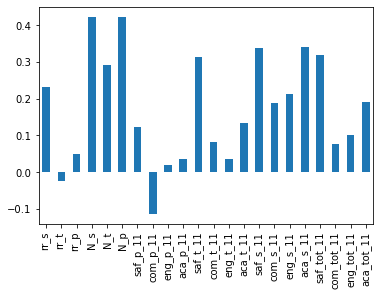

In [14]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.

survey_fields.remove("DBN")
correlations[survey_fields].plot.bar()

- As expected, factors indicating higher levels of enrollment (`N_s`, `N_t`, `N_p`) have a high positive correlation with SAT scores.
<br><br>
- Both students' and teachers' opinions on safety and respect at school (`saf_s_11`, `saf_t_11`) had a high positive correlation, with those of parents' (`saf_p_11`) less so.
<br><br>
- Interesting that higher SAT scores were achieved at schools where the students expected to perform well (`aca_s_11`), while the academic expectations of parents and teachers (`aca_p_11`, `aca_t_11`) had a significantly lower correlation.

## Investigating safety scores

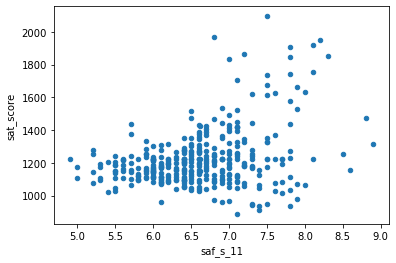

In [15]:
combined.plot.scatter(x='saf_s_11', y='sat_score')

The plot shows some correlation between SAT scores and safety, although not that strong. Of the schools that have a high safety score (above 8), some also achieved high SAT scores, while others performed relatively poorly. The majority of schools have a safety rating below 7, and virtually all of these schools scored below 1600 in the SAT.

In [16]:
# calculate the average scores for each district

districts = combined.groupby('school_dist').agg(np.mean)
districts.reset_index(inplace=True)
districts.head()

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
0,01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
1,02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
2,03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
3,04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251


/Users/keiran/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


/Users/keiran/anaconda3/envs/tf2/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


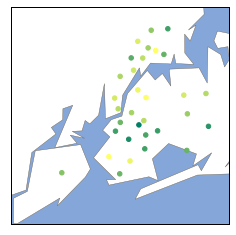

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# plot 

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white', lake_color='#85A6D9')

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m.scatter(x=longitudes, y=latitudes, s=20, zorder=2, latlon=True, c=districts['saf_s_11'], cmap='summer')
plt.show()

In general it appears that Manhattan, Queens and the Bronx tend to have higher safety scores, while Brooklyn has lower safety scores.

## Investigating racial differences in SAT scores

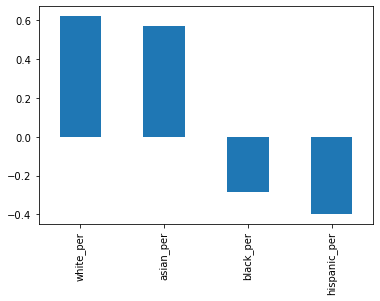

In [18]:
race_fields = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
correlations[race_fields].plot.bar()

We can observe a clear disparity between races:
- the percentage of white and asian students correlates very strongly with higher SAT scores
- the percentage of black and hispanic students correlates with lower SAT scores

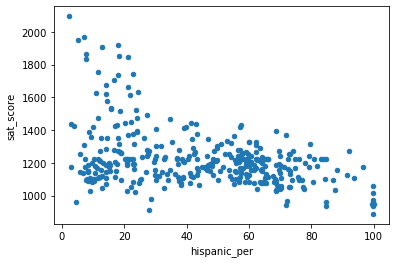

In [19]:
combined.plot.scatter(x='hispanic_per', y='sat_score')

The plot shows a clear trend in SAT scores decreasing as percentage of hispanic students increases. The best performing schools had a very low percentage of hispanic students, while fully hispanic schools achieved some of the worst scores.

In [20]:
# find the schools with >95% hispanic percentage

print(combined[combined['hispanic_per'] > 95]['SCHOOL NAME'])

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Above is a list of schools with >95% hispanic students. Nearly all of them cater specifically for recently arrived Spanish speaking students, hence the high percentage.

In [21]:
# find schools with <10% hispanic percentage and >1800 SAT score

print(combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]['SCHOOL NAME'])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Above is a list of schools with a hispanic student percentage of less than 10% that achieved a SAT score greater than 1800. All of them have highly competitive entry and offer specialised technical courses with advanced college placement and research opportunities. 

## Investigating gender differences in SAT scores

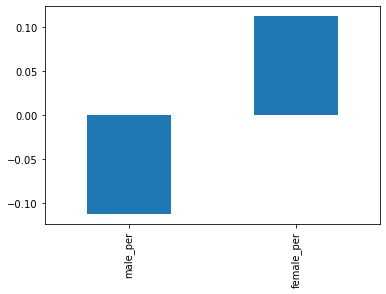

In [22]:
gender_fields = ['male_per', 'female_per']
correlations[gender_fields].plot.bar()

The chart shows a positive correlation between percentage of female students and SAT score, and a negative correlation between percentage of male students and SAT score. Both are relatively weak.

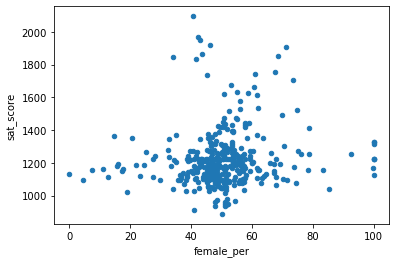

In [23]:
combined.plot.scatter(x='female_per', y='sat_score')

The plot shows an upward trend in SAT scores for some higher performing schools as percentage of female students increases, although its interesting to note that of all the schools with scores above 1800, almost 80% had less than a 50% share of female students.
The five schools with 100% female student percentage all scored around average (1223).

In [24]:
# find schools with >60% female_per and sat_score > 1700

print(combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]['SCHOOL NAME'])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Listed above are the schools with a percentage of female students over 60% that scored higher than 1700 in the SAT. A feature common among all is academically challenging coursework with high quality instruction. Bard High School and Eleanor Roosevelt High School focus on college preparation, with two years of study potentially counting towards college credit in the case of Bard. Beacon High School and Fiorello H. LaGuardia High School have a strong focus on arts, with LaGuardia offering 2-3 hours per day of arts specialisation - this may explain the higher percentage of female students. 

## Investigating the relationship between AP scores and SAT scores

In [25]:
# calculate percentage of students that took at least one AP test

combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

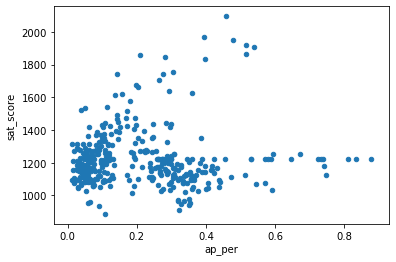

In [26]:
combined.plot.scatter(x='ap_per', y='sat_score')

The plot shows a somewhat weak positive correlation between the percentage of students that took an AP test and SAT scores. 

## Investigating the relationship between class size and SAT scores

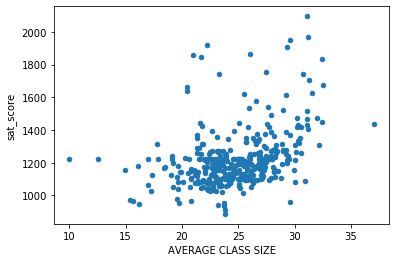

In [27]:
combined.plot.scatter(x='AVERAGE CLASS SIZE', y='sat_score')

There appears to be a significant positive correlation between class size and SAT scores. This is somewhat counter-intuitive, as one might expect that smaller classes would lead to increased teacher attention per student.